## TD Abs[HHB2] Fitting

In [1]:
import pandas as pd
import glob
import os
import numpy as np
import sys
! pip install pmcx

In [2]:
from google.colab import drive
drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/MCX_data'
sys.path.append(folder_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from FD_msNIRS_2layers import extract_freq as ef

### Read Simulation data

In [4]:
import os
import pickle
import numpy as np
from pathlib import Path
import os, re

In [5]:
result_folder1 = '/content/drive/MyDrive/MCX_data/result_folder/stage2/part1/'
result_folder2 = '/content/drive/MyDrive/MCX_data/result_folder/stage2/part2/'
result_folder3 = '/content/drive/MyDrive/MCX_data/result_folder/stage2/part3/'
result_folder4 = '/content/drive/MyDrive/MCX_data/result_folder/stage2/part4/'
result_folder5 = '/content/drive/MyDrive/MCX_data/result_folder/stage2/part5/'
result_folder6 = '/content/drive/MyDrive/MCX_data/result_folder/stage2/part6/'
result_folder7 = '/content/drive/MyDrive/MCX_data/result_folder/stage2/part7/'
result_folder8 = '/content/drive/MyDrive/MCX_data/result_folder/stage2/part8/'
result_folder9 = '/content/drive/MyDrive/MCX_data/result_folder/stage2/part9/'
result_folder10 = '/content/drive/MyDrive/MCX_data/result_folder/stage2/part10/'
rf = [result_folder1, result_folder2, result_folder3, result_folder4, result_folder5, result_folder6, result_folder7, result_folder8, result_folder9, result_folder10]

In [6]:
def matrix_construct(dictt):
    re = np.zeros((64, 1000))
    di = 0
    for k, v in dictt.items():  # eight distances
        TPSF_list = v
        for i in range(8):
            re[di, :] = TPSF_list[i]
            di += 1
    return re

In [7]:
def load_and_process_all(result_folders):
    """
    Collect every *.pkl* file inside one or many folders, sort them by the
    numeric ID in the filename, and return

        • all_rows  : stacked (n_samples × 96) NumPy array
        • sorted_ids: list[int] with the same order as all_rows

    A filename can be “123.pkl”, “123 (1).pkl”, “123_dup2.pkl”, etc.
    Only the **first** file encountered for each numeric ID is kept.
    """
    # --- 1.  Normalise the input ------------------------------------------------
    if isinstance(result_folders, (str, Path)):
        result_folders = [result_folders]            # allow a single path
    result_folders = [Path(p) for p in result_folders]

    # --- 2.  Collect full paths to every .pkl file ------------------------------
    pkl_paths = []
    for folder in result_folders:
        pkl_paths.extend([p for p in folder.iterdir() if p.suffix == ".pkl"])

    # --- 3.  Build a mapping {numeric_id: first_path_seen} ----------------------
    id_to_path = {}
    for p in pkl_paths:
        # Extract the leading integer part of the filename
        stem = p.stem.split()[0].split("_")[0]       # handles “123”, “123 (1)”, “123_dup2”
        try:
            id_num = int(stem)
        except ValueError:
            continue                                 # skip files like “model.pkl” etc.

        # Keep the first file we see for each ID
        id_to_path.setdefault(id_num, p)

    # --- 4.  Sort by ID ----------------------------------------------------------
    sorted_ids = sorted(id_to_path.keys())
    sorted_paths = [id_to_path[i] for i in sorted_ids]

    # --- 5.  Load & convert each file -------------------------------------------
    rows = []
    for path in sorted_paths:
        with open(path, "rb") as f:
            data_dict = pickle.load(f)
        row = matrix_construct(data_dict)
        rows.append(row)

    #all_rows = np.vstack(rows)
    return rows, sorted_ids

In [8]:
final_array, sorted_ids = load_and_process_all(rf)

In [9]:
len(final_array)

5000

In [10]:
#eps = 1e-9                              # small positive offset
# Safely take ln() for every (32, 2000) array in the list
#final_array = [np.log(np.clip(a, eps, None)) for a in final_array]
print(final_array[0].shape)             # → (32, 2000)

(64, 1000)


In [11]:
len(sorted_ids)

5000

### GT

In [12]:
GT_folder = '/content/drive/MyDrive/MCX_data/stage2_csv/'

In [13]:
csv_files = glob.glob(os.path.join(GT_folder, '*.csv'))
GT_all = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)

In [14]:
GT_all.head()

,HBO1,HHB1,HBO2,HHB2,d1,a1,a2,b1,b2,ID
0,14.209716,6.363222,45.917948,19.337672,13.0,6.766997,1.181103,1.939614,2.599744,9001
1,6.709716,11.363222,30.917948,29.337672,18.0,3.766997,2.731103,0.739614,1.099744,9002
2,10.459716,3.863222,53.417948,24.337672,11.0,5.266997,1.956103,1.339614,0.349744,9003
3,17.959716,8.863222,38.417948,34.337672,16.0,2.266997,3.506103,0.139614,1.849744,9004
4,16.084716,2.613222,27.167948,21.837672,20.0,3.016997,3.893603,0.439614,2.224744,9005


In [15]:
# Ensure ID column is integer
GT_all['ID'] = GT_all['ID'].astype(int)

# Filter and sort GT_all to match the sorted_ids order
GT_filtered = GT_all[GT_all['ID'].isin(sorted_ids)].copy()
GT_filtered = GT_filtered.set_index('ID').loc[sorted_ids].reset_index()

# Extract HHB2 as Y
Y = GT_filtered['HHB2'].values  # numpy array (n_samples,)
Y = Y.reshape(-1, 1)

In [16]:
Y.shape

(5000, 1)

In [19]:
X = np.stack(final_array)
print(X.shape)

(5000, 64, 1000)


#### scale X and Y

In [20]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Reshape X to (n_samples, features)
X_flat = X.reshape(X.shape[0], -1)  # (120, 32000)

# Scale X
scaler_X = StandardScaler()
X_flat_scaled = scaler_X.fit_transform(X_flat)

# Reshape back to original 3D shape
X = X_flat_scaled.reshape(X.shape[0], 64, 1000)

# Scale Y
scaler_y = StandardScaler()
Y = scaler_y.fit_transform(Y)

In [21]:
np.max(X)

np.float64(70.70360669725343)

In [22]:
np.max(Y)

np.float64(1.7313706919206298)

In [24]:
print(X.shape)
print(Y.shape)

(5000, 64, 1000)
(5000, 1)


In [25]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Step 1: Train/test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

### ANN

In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation, Add,
    MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
)

def residual_block(x, filters, kernel_size=(5, 5), downsample=False, dropout_rate=0.0):
    shortcut = x

    # First conv
    x = Conv2D(filters, kernel_size, padding='same', strides=(2, 2) if downsample else (1, 1))(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)

    # Second conv
    x = Conv2D(filters, kernel_size, padding='same')(x)

    # Shortcut path
    if downsample or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), strides=(2, 2) if downsample else (1, 1), padding='same')(shortcut)

    # Merge
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# Input
input_tensor = Input(shape=(64, 1000, 1))

# Initial Conv Layer
x = Conv2D(32, (3, 3), padding='same', activation='relu')(input_tensor)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Residual Blocks
x = residual_block(x, 128, downsample=True, dropout_rate=0.0)
x = residual_block(x, 128)

x = residual_block(x, 128, downsample=True, dropout_rate=0.0)
x = residual_block(x, 128)

x = residual_block(x, 256, downsample=True, dropout_rate=0.0)
x = residual_block(x, 256)

# Global Average Pooling
x = GlobalAveragePooling2D()(x)

# Dense Head
x = Dense(128, activation='relu')(x)
x = Dropout(0.0)(x)
x = Dense(64, activation='relu')(x)
x = Dense(1)(x)

# Build model
resnet_model = Model(inputs=input_tensor, outputs=x)

# 1) Create a checkpoint callback that saves the best model:
checkpoint_cb = ModelCheckpoint(
    "best_model.keras",        # filepath to save to
    monitor="val_loss",     # quantity to monitor
    mode="min",             # we want to minimize val_loss
    save_best_only=True,    # only save when val_loss decreases
    save_weights_only=False # set True if you only want weights
)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
resnet_model.compile(optimizer=optimizer, loss="mse")

# 3) Fit with the checkpoint callback
history = resnet_model.fit(
    X_train, Y_train,
    epochs=300,
    batch_size=32,
    validation_split=0.1,
    verbose=1,
    callbacks=[checkpoint_cb]
)

# 4) Later on (or in a new script), load the best model:
model = tf.keras.models.load_model("best_model.keras")

Epoch 1/300
127/127 ━━━━━━━━━━━━━━━━━━━━ 43s 248ms/step - loss: 0.9417 - val_loss: 0.5015
Epoch 2/300
127/127 ━━━━━━━━━━━━━━━━━━━━ 15s 115ms/step - loss: 0.5466 - val_loss: 0.5961
Epoch 3/300
127/127 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - loss: 0.4844 - val_loss: 0.3719
Epoch 4/300
127/127 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - loss: 0.4452 - val_loss: 0.3462
Epoch 5/300
127/127 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - loss: 0.4031 - val_loss: 0.3028
Epoch 6/300
127/127 ━━━━━━━━━━━━━━━━━━━━ 14s 114ms/step - loss: 0.3319 - val_loss: 0.3090
Epoch 7/300
127/127 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - loss: 0.3115 - val_loss: 0.2725
Epoch 8/300
127/127 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - loss: 0.2693 - val_loss: 0.2239
Epoch 9/300
127/127 ━━━━━━━━━━━━━━━━━━━━ 14s 114ms/step - loss: 0.2420 - val_loss: 0.2270
Epoch 10/300
127/127 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - loss: 0.1996 - val_loss: 0.1681
Epoch 11/300
127/127 ━━━━━━━━━━━━━━━━━━━━ 14s 114ms/step - loss: 0.1536 - val_loss: 0.1699
Epoch 12

In [30]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 64, 1000,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 64, 1000,  │        320 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 500,   │          0 │ conv2d_48[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 16, 250,   │    102,528 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_36       │ (None, 16, 250,   │          0 │ conv2d_49[0][0]   │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 16, 250,   │          0 │ activation_36[0]… │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 16, 250,   │    409,728 │ dropout_21[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (None, 16, 250,   │      4,224 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 16, 250,   │          0 │ conv2d_50[0][0],  │
│                     │ 128)              │            │ conv2d_51[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_37       │ (None, 16, 250,   │          0 │ add_18[0][0]      │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_52 (Conv2D)  │ (None, 16, 250,   │    409,728 │ activation_37[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_38       │ (None, 16, 250,   │          0 │ conv2d_52[0][0]   │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 16, 250,   │          0 │ activation_38[0]… │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 16, 250,   │    409,728 │ dropout_22[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_19 (Add)        │ (None, 16, 250,   │          0 │ conv2d_53[0][0],  │
│                     │ 128)              │            │ activation_37[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_39       │ (None, 16, 250,   │          0 │ add_19[0][0]      │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 8, 125,    │    409,728 │ activation_39[0]

 Total params: 26,404,037 (100.72 MB)

 Trainable params: 8,801,345 (33.57 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,602,692 (67.15 MB)

In [31]:
# Predict and evaluate
y_pred = resnet_model.predict(X_test)
mse = mean_squared_error(Y_test, y_pred)
print(f"Test MSE: {mse:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 487ms/step
Test MSE: 0.1121


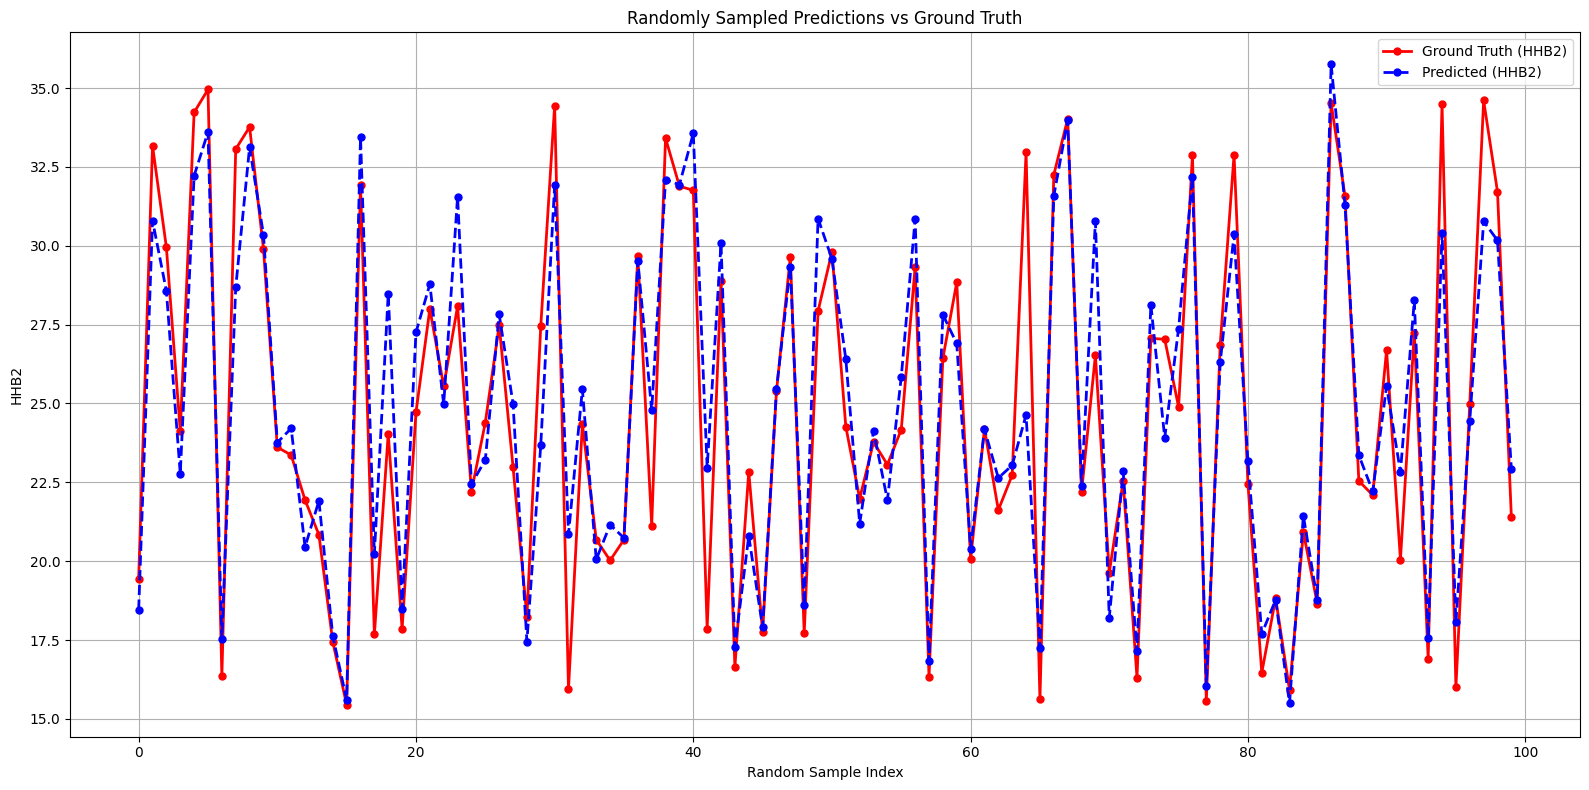

In [32]:
# Randomly select 100 indices
indices = np.random.choice(len(Y_test), size=100, replace=False)
indices = np.sort(indices)

y_pred_rescaled = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test_rescaled = scaler_y.inverse_transform(Y_test.reshape(-1, 1)).flatten()

# Extract corresponding values
y_test_sampled = y_test_rescaled[indices]
y_pred_sampled = y_pred_rescaled[indices]

# Plot with circular markers
plt.figure(figsize=(16, 8))
plt.plot(y_test_sampled, 'r-o', label='Ground Truth (HHB2)', linewidth=2, markersize=5)
plt.plot(y_pred_sampled, 'b--o', label='Predicted (HHB2)', linewidth=2, markersize=5)
plt.xlabel('Random Sample Index')
plt.ylabel('HHB2')
plt.title('Randomly Sampled Predictions vs Ground Truth')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Test MSE (original scale): 3.7379


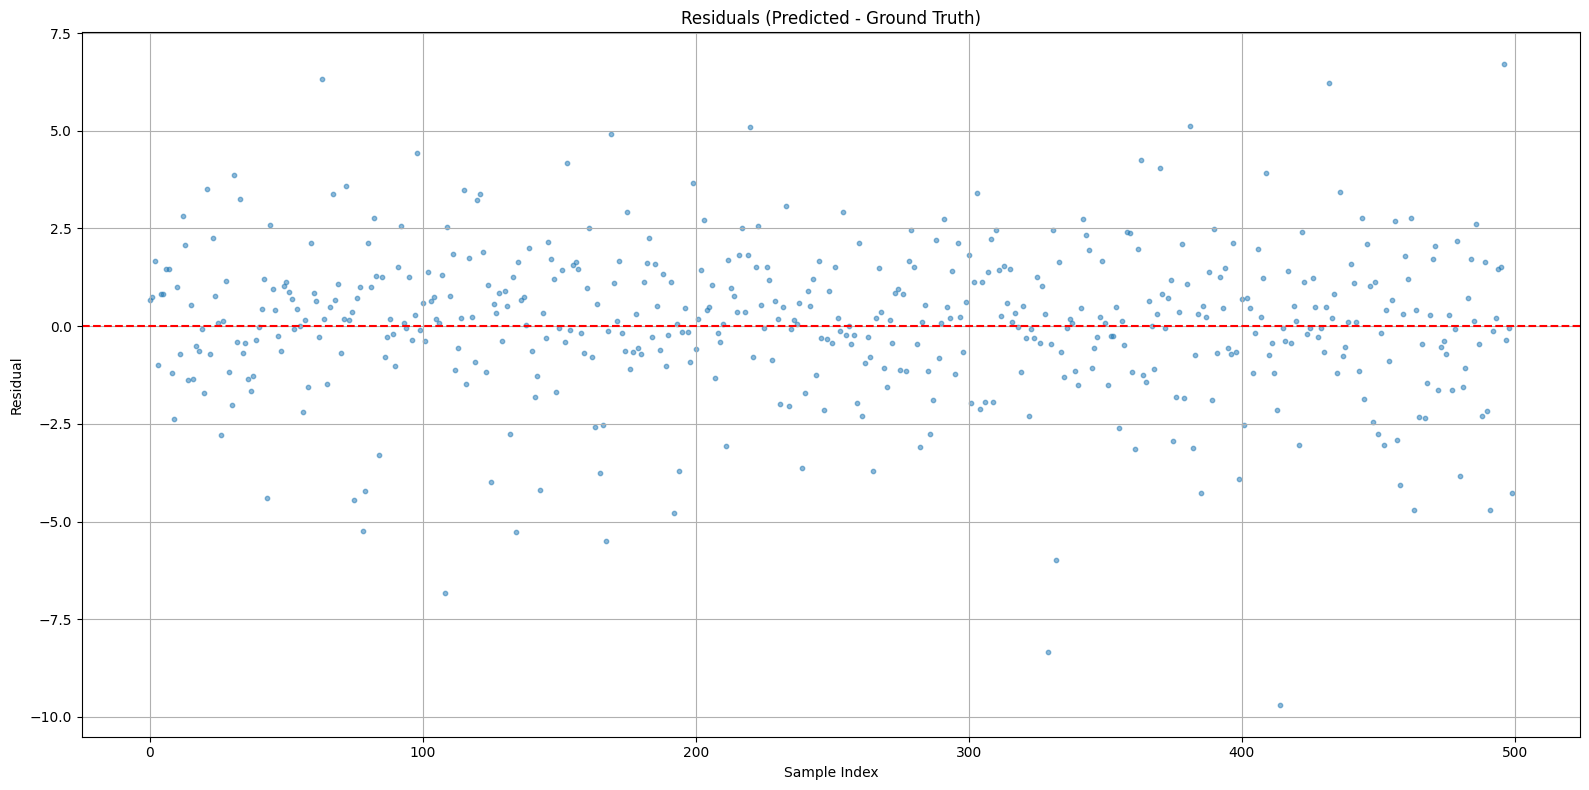

In [33]:

# Compute residuals in original scale
residuals = y_pred_rescaled - y_test_rescaled

mse_rescaled = mean_squared_error(y_pred_rescaled, y_test_rescaled)
print(f"Test MSE (original scale): {mse_rescaled:.4f}")

# Plot residuals
plt.figure(figsize=(16, 8))
plt.scatter(range(len(residuals)), residuals, s=10, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.title("Residuals (Predicted - Ground Truth)")
plt.ylabel("Residual")
plt.xlabel("Sample Index")
plt.grid(True)
plt.tight_layout()
plt.show()

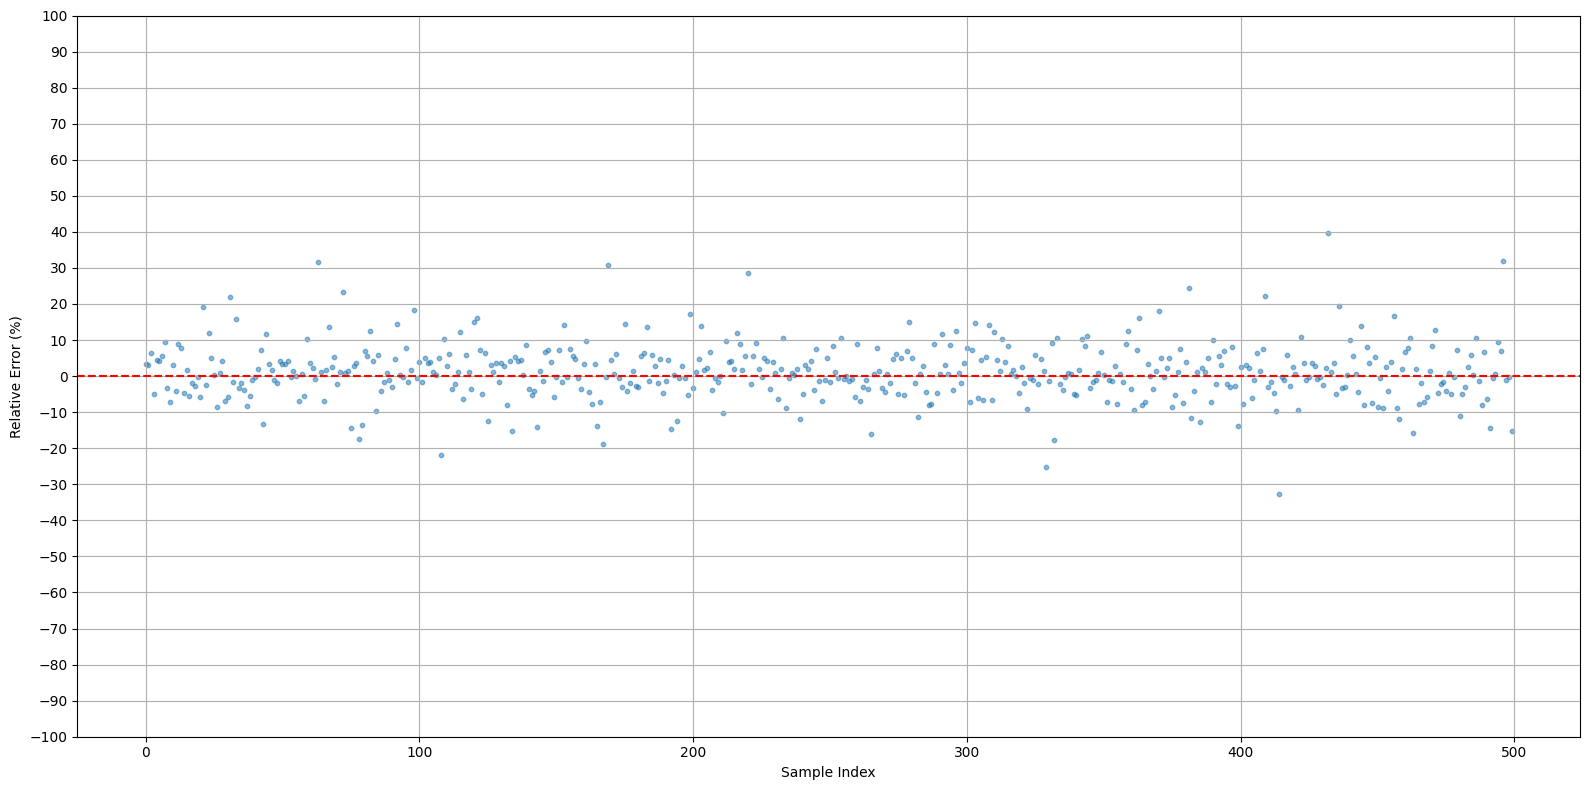

In [42]:
# Compute relative error (percentage)
relative_error = ((y_pred_rescaled - y_test_rescaled) / y_test_rescaled) * 100

# Plot relative error
plt.figure(figsize=(16, 8))
plt.scatter(range(len(relative_error)), relative_error, s=10, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.ylabel("Relative Error (%)")
plt.yticks(np.arange(-100, 101, 10))
plt.xlabel("Sample Index")
plt.grid(True)
plt.tight_layout()
plt.show()

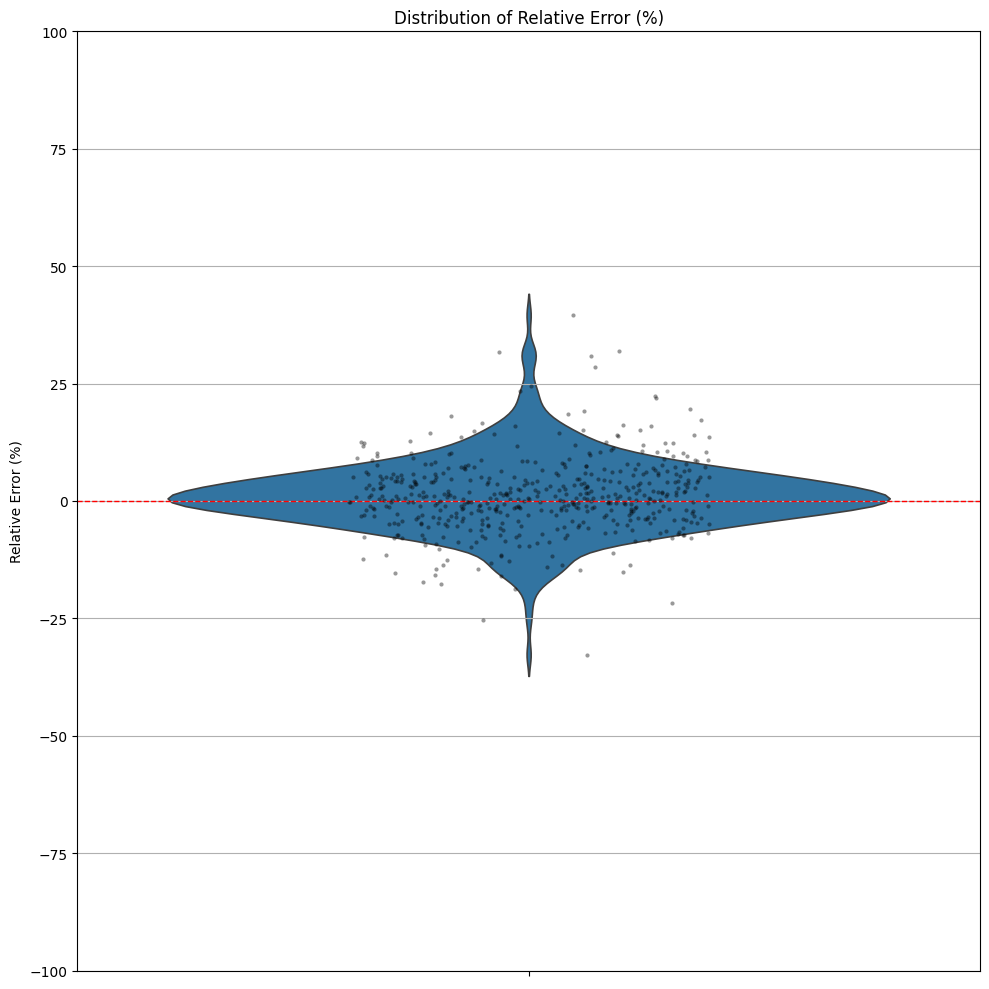

In [35]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Prepare DataFrame for seaborn
df_plot = pd.DataFrame({
    'Relative Error (%)': relative_error.flatten()
})

plt.figure(figsize=(10, 10))
sns.violinplot(data=df_plot, y='Relative Error (%)', inner=None, linewidth=1.2)
sns.stripplot(data=df_plot, y='Relative Error (%)', color='black', alpha=0.4, jitter=0.2, size=3)

plt.axhline(0, color='r', linestyle='--', linewidth=1)
plt.ylim(-100, 100)
plt.title('Distribution of Relative Error (%)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


R² = 0.8861918826623406
MAPE = 5.679296998760601 %


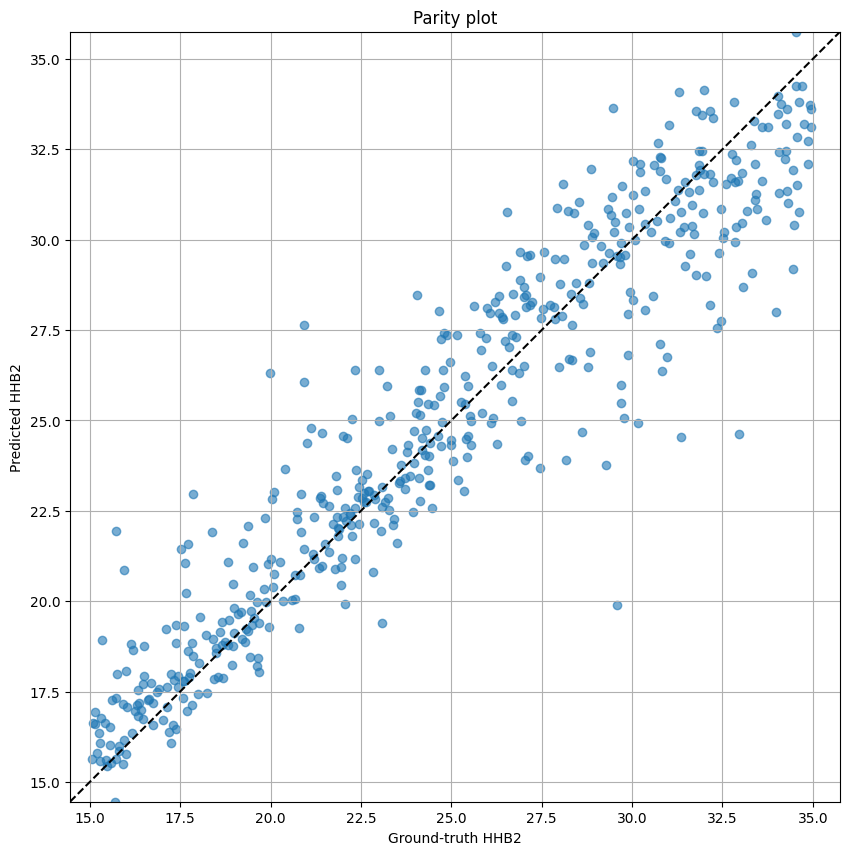

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_percentage_error

plt.figure(figsize=(10,10))
plt.scatter(y_test_rescaled, y_pred_rescaled, alpha=0.6)
lims = [min(y_test_rescaled.min(), y_pred_rescaled.min()),
        max(y_test_rescaled.max(), y_pred_rescaled.max())]
plt.plot(lims, lims, 'k--')              # identity line
plt.xlabel('Ground-truth HHB2'); plt.ylabel('Predicted HHB2')
plt.title('Parity plot')
plt.axis('square'); plt.xlim(lims); plt.ylim(lims)
plt.grid()
print("R² =", r2_score(y_test_rescaled, y_pred_rescaled))
print("MAPE =", mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)*100, "%")
plt.show()


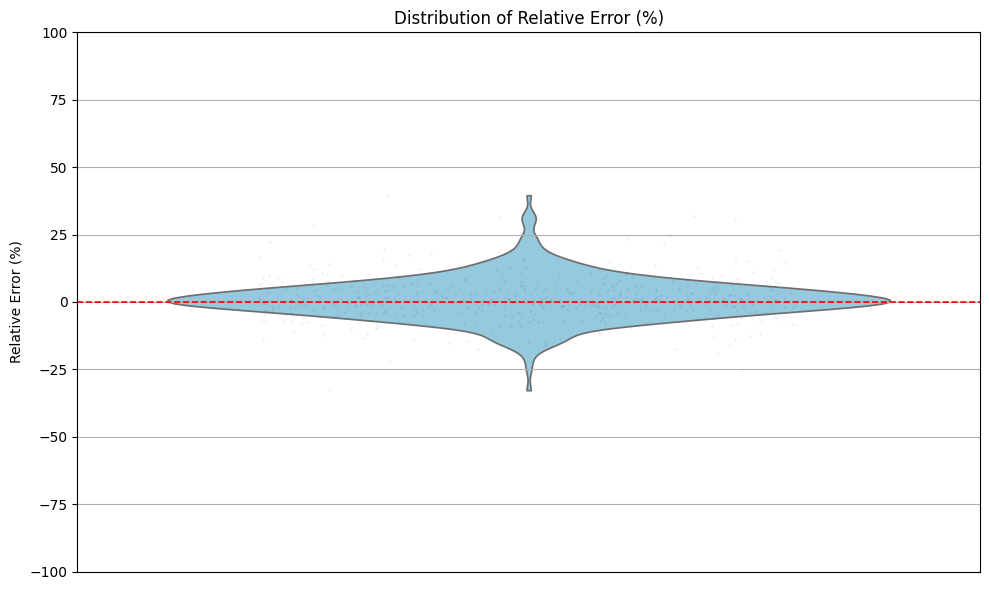

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(10, 6))
sns.violinplot(y=relative_error, inner=None, color='skyblue', cut=0)
sns.stripplot(y=relative_error, color='black', alpha=0.05, jitter=0.3, size=2)

plt.axhline(0, color='red', linestyle='--', linewidth=1.2)
plt.title('Distribution of Relative Error (%)')
plt.ylabel('Relative Error (%)')
plt.grid()
plt.xticks([])
plt.ylim(-100, 100)
plt.tight_layout()
plt.show()



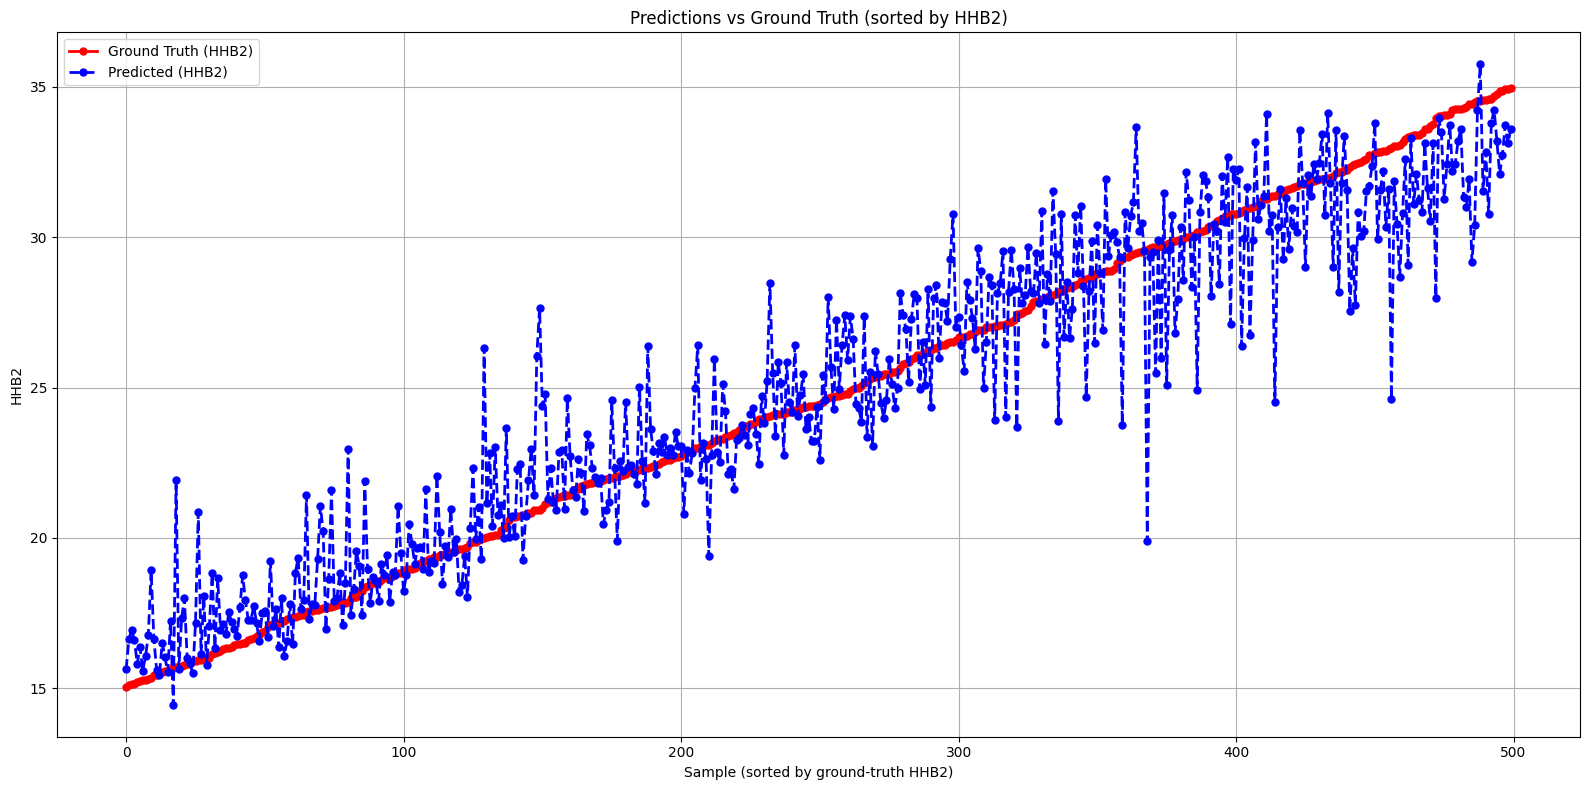

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# ── Sort by ground-truth values (ascending) ───────────────────────────────
sorted_idx       = np.argsort(y_test_rescaled)         # indices that sort y_test
y_test_sorted    = y_test_rescaled[sorted_idx]
y_pred_sorted    = y_pred_rescaled[sorted_idx]

# ── Plot both curves with matching order ──────────────────────────────────
plt.figure(figsize=(16, 8))
plt.plot(y_test_sorted, 'r-o',  label='Ground Truth (HHB2)', linewidth=2, markersize=5)
plt.plot(y_pred_sorted, 'b--o', label='Predicted (HHB2)',   linewidth=2, markersize=5)
plt.xlabel('Sample (sorted by ground-truth HHB2)')
plt.ylabel('HHB2')
plt.title('Predictions vs Ground Truth (sorted by HHB2)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


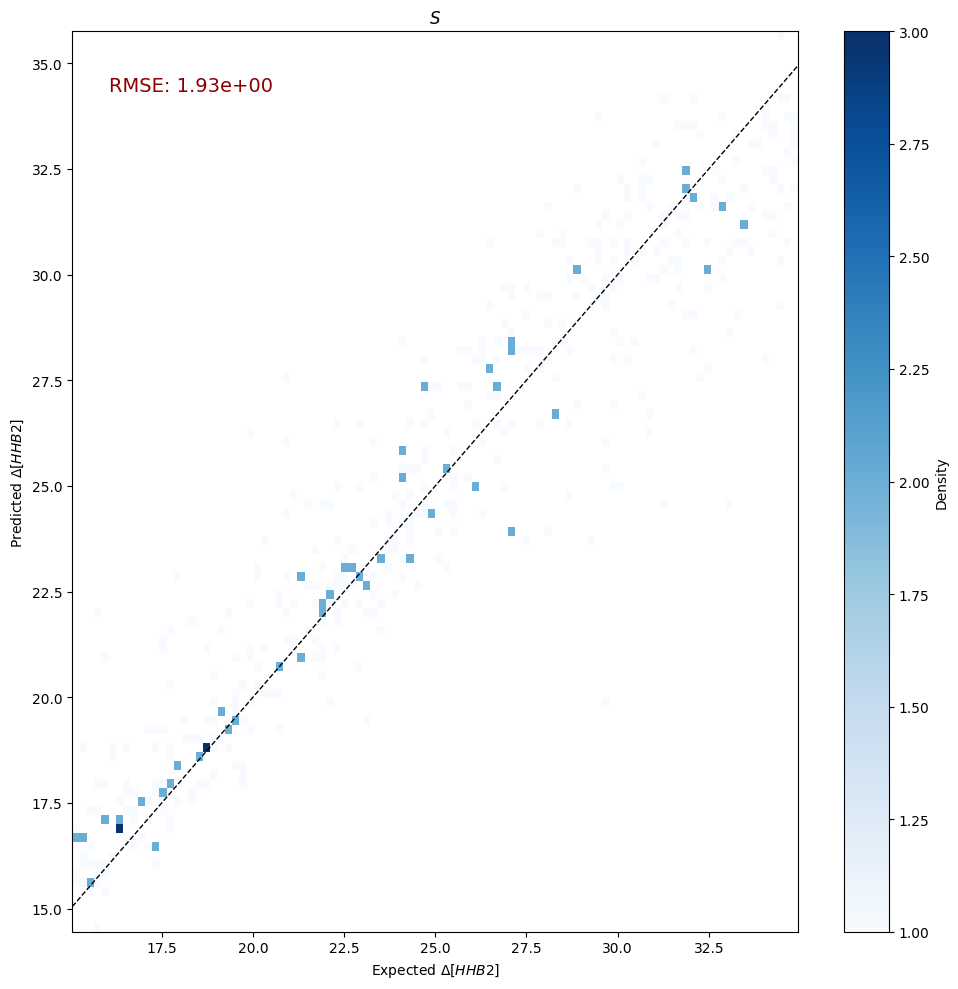

In [39]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

# Ensure y_true and y_pred are 1D numpy arrays
y_true = np.asarray(y_test_rescaled).ravel()
y_pred =np.asarray(y_pred_rescaled).ravel()

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Plot
plt.figure(figsize=(10, 10))
plt.hist2d(y_true, y_pred, bins=100, cmap='Blues', cmin=1)

# Plot identity line
plt.plot([min(y_true), max(y_true)],
         [min(y_true), max(y_true)],
         'k--', lw=1)

# Labels and title
plt.xlabel('Expected $\Delta[HHB2]$')
plt.ylabel('Predicted $\Delta[HHB2]$')
plt.title(r'$S$')

# Annotate RMSE
plt.text(0.05, 0.95, f'RMSE: {rmse:.2e}', color='darkred',
         fontsize=14, transform=plt.gca().transAxes, va='top')

plt.colorbar(label='Density')
plt.tight_layout()
plt.show()

In [40]:
# Small epsilon to avoid division by zero
eps = 1e-8

# Relative error (%)
relative_error = (y_pred - y_true) / (y_true + eps) * 100
absolute_relative_error = np.abs(relative_error)

# Compute metrics
mre = np.mean(relative_error)
mape = np.mean(absolute_relative_error)

# Print
#print(f"Mean Relative Error (MRE): {mre:.4f}%")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")

Mean Absolute Percentage Error (MAPE): 5.6793%


In [43]:
lower, upper = np.percentile(relative_error, [16, 84])
print(f"68% CI of HHb₂ % error: {lower:.2f}% to {upper:.2f}%")

68% CI of HHb₂ % error: -5.27% to 7.36%


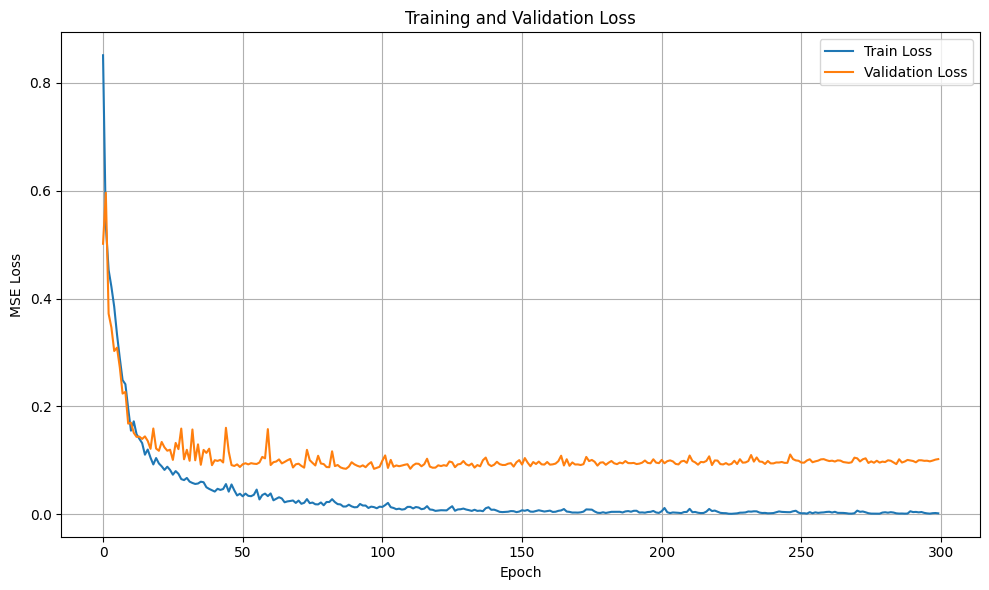

In [41]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()